In [ ]:
!pip install statsforecast

In [104]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
from utils import RenameColumns, CastToFloat, CastToDatetime, FillMissingData, AddColumn, SetIndex, TransformIndexToColumn
from sklearn.pipeline import Pipeline
import warnings
import plotly.graph_objects as go
sns.set_style('darkgrid')

from google.colab import auth
from google.cloud import bigquery

from sklearn.metrics import mean_squared_error
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, Naive, SeasonalExponentialSmoothingOptimized,
                                  SeasonalNaive, SeasonalWindowAverage)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

## Objetivo


O objetivo deste projeto é a predição do preço diário do barril de petróleo bruto Brent através da análise dos dados históricos.


## Base de Dados


Para a realização desta análise, serão utilizados dados de periodicidade diária, obtidos no site do IPEA (http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view).

O IPEA, Instituto de Pesquisa Econômica Aplicada, é uma instituição brasileira vinculada ao governo federal. Ele foi criado em 1964 e tem como objetivo realizar pesquisas e estudos econômicos aplicados para subsidiar o governo na formulação e avaliação de políticas públicas.



A base de dados contém as seguintes informações:

**Data:** Data em que as informações foram registradas

**Preço Petróleo Bruto Brent:** preço em dólar do barril de petróleo bruto Brent

## Transformação de Dados

Para a transformação, foi realizada a leitura dos dados da tabela "petroleo_brent" armazenada no Google Big Query e as colunas foram ajustadas para o padrão de time series.

Devido a falta de dados nos finais de semana e feriados, por não haver comercialização de petróleo nestes dias, o valor do fechamento do último dia útil disponível será utilizado para preencher esses gaps, uma vez que os modelos de séries temporais necessitam que a periodicidade seja uniforme durante todo o período.

In [57]:
auth.authenticate_user()

In [58]:
project_id = 'fiap-tech-challenge-4'
dataset_id = 'tech_challenge_4'
table_id = 'petroleo_brent'

In [59]:
client = bigquery.Client(project = project_id)

In [60]:
query = f'SELECT * FROM {project_id}.{dataset_id}.{table_id} order by data desc;'

query_job = client.query(query)
df_preco_petroleo = query_job.to_dataframe()

df_preco_petroleo.head()

,data,preco_petroleo_brent
0,2024-01-16,80.15
1,2024-01-15,79.76
2,2024-01-12,79.89
3,2024-01-11,80.21
4,2024-01-10,78.46


In [61]:
df_preco_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11088 entries, 0 to 11087
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   data                  11088 non-null  datetime64[ns]
 1   preco_petroleo_brent  11088 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


In [62]:
pipeline = Pipeline([
  ('rename_columns', RenameColumns()),
  ('cast_to_datetime', CastToDatetime()),
  ('fill_missing_data', FillMissingData()),
  ('set_index', SetIndex())
])

In [63]:
df_preco_petroleo = pipeline.transform(df_preco_petroleo)

In [64]:
df_preco_petroleo.head()

,y
ds,
2024-01-16,80.15
2024-01-15,79.76
2024-01-14,79.89
2024-01-13,79.89
2024-01-12,79.89


## Visão Geral dos Dados

O gráfico acima apresenta o preço do barril do petróleo bruto Brent comercializado ao longo dos anos.

In [65]:
fig = px.line(df_preco_petroleo, title='Preço por Barril do Petróleo Bruto Brent')
fig.update_xaxes(title='Data')
fig.update_yaxes(title='Preço (US$)')
fig.show()

### Crise Econômica Global de 2008

Através da análise do gráfico, pode-se constatar um aumento acentuado no preço do barril do petróleo bruto Brent de 2007 até a primeira metade de 2008, atingindo o preço máximo histórico em julho de 2008 de US$ 143.95 dólares. Esse aumento no preço pode ser atribuído a uma combinação de fatores econômicos e geopolíticos, como exemplo:


+ **Demanda Global Crescente:** A forte demanda por petróleo, especialmente da China e de outros países em desenvolvimento, impulsionou os preços. O crescimento econômico global, especialmente nos setores industrial e de transporte, aumentou a necessidade de energia.

+ **Instabilidade Geopolítica:** Tensões geopolíticas em várias regiões produtoras de petróleo, como o Oriente Médio e o Norte da África, contribuíram para a incerteza quanto ao fornecimento. Eventos como a escalada de conflitos no Iraque, a instabilidade no Irã e a interrupção da produção na Nigéria impactaram as perspectivas de oferta, elevando os preços.

+ **Dólar Americano Fraco:** O enfraquecimento do dólar norte-americano também desempenhou um papel significativo. O petróleo é cotado em dólar, e quando o valor do dólar cai, os preços do petróleo tendem a subir para compensar a perda de valor da moeda.

+ **Restrições na Oferta:** Limitações na capacidade de produção da Organização dos Países Exportadores de Petróleo (OPEP) e a dificuldade em aumentar rapidamente a produção de petróleo em resposta à crescente demanda também exerceram pressão sobre os preços.



Contudo, esse aumento significativo no preço do barril do petróleo teve um impacto significativo na economia global, culminando, dentre outros fatores, na **Crise Econômica** que se desdobrou na segunda metade de 2008, devido a:



+ **Pressão sobre os Consumidores:** O aumento nos preços do petróleo resultou em custos mais elevados para os consumidores, especialmente no que diz respeito aos gastos com combustíveis e produtos derivados de petróleo. Isso reduziu a renda disponível das famílias, afetando negativamente o consumo e desencadeando uma desaceleração econômica.

+ **Inflação:** O aumento nos preços do petróleo contribuiu para a inflação, à medida que os custos de produção aumentaram para várias indústrias. Isso levou a um ambiente econômico em que os bancos centrais foram desafiados a equilibrar a necessidade de controlar a inflação e, ao mesmo tempo, estimular o crescimento econômico.

+ **Impacto nos Setores Sensíveis:** Setores intensivos em energia, como transporte, manufatura e agricultura, foram particularmente afetados pelos preços elevados do petróleo. Empresas nesses setores enfrentaram aumentos nos custos operacionais, levando a cortes de empregos e redução de investimentos.

+ **Desencadeamento de Crises Financeiras em Outros Setores:** O impacto inicial nos preços do petróleo desencadeou uma série de eventos que amplificaram a crise. As dificuldades enfrentadas por consumidores e empresas no pagamento de dívidas levaram a uma crise no mercado de hipotecas subprime nos Estados Unidos, que acabou se espalhando para o sistema financeiro global.

+ **Desaceleração Econômica Global:** A combinação de inflação, custos mais elevados e redução do consumo levou a uma desaceleração econômica global. Isso exacerbou os desafios enfrentados por instituições financeiras já sob pressão devido à crise do mercado imobiliário.    


A Crise Econômica Global abalou os alicerces do mercado financeiro e esse fato reverberou nos preços do petróleo Brent, resultando em uma queda expressiva, conforme evidenciado abaixo:

In [66]:
fig = px.line(df_preco_petroleo.sort_index().loc['2007-01-01' : '2009-04-01'], title='Preço por Barril do Petróleo Bruto Brent')
fig.update_xaxes(title='Data')
fig.update_yaxes(title='Preço (US$)', range=[2, 150])
fig.update_layout(width = 700)
fig.show()

### Primavera Árabe


A Primavera Árabe foi uma série de protestos, revoltas e manifestações populares que eclodiram em vários países do Oriente Médio e do Norte da África a partir de 2010. Esses eventos foram impulsionados por uma combinação de fatores, incluindo descontentamento político, social e econômico, além do desejo por reformas democráticas. Os países mais notoriamente afetados incluíram Tunísia, Egito, Líbia, Síria e Iêmen.

A influência da Primavera Árabe no preço do petróleo Brent pode ser compreendida em vários pontos-chave:

- **Instabilidade Geopolítica:** A Primavera Árabe desencadeou instabilidades geopolíticas significativas na região do Oriente Médio e Norte da África. Conflitos e incertezas políticas em países produtores de petróleo, como Líbia e Síria, afetaram as operações de produção e exportação de petróleo, gerando preocupações sobre a oferta global.

- **Interrupções na Produção e Exportação:** Em países onde os protestos evoluíram para conflitos armados, como a Líbia, as interrupções na produção e exportação de petróleo contribuíram para a volatilidade nos preços do petróleo Brent. A oferta restrita em meio à demanda contínua resultou em picos nos preços do petróleo.

- **Desafios para a OPEP:** A Organização dos Países Exportadores de Petróleo (OPEP) enfrentou desafios significativos durante a Primavera Árabe. A capacidade da OPEP para coordenar a produção e estabilizar os preços foi prejudicada pela instabilidade em alguns de seus membros-chave, afetando a influência do grupo sobre o mercado de petróleo.

- **Impacto na Economia Global:** A instabilidade nos preços do petróleo Brent devido à Primavera Árabe teve implicações na economia global. A elevação dos preços do petróleo contribuiu para custos mais altos de produção e transporte em vários setores econômicos, impactando o crescimento econômico global.

Ou seja, a Primavera Árabe influenciou os preços do petróleo Brent principalmente através da instabilidade geopolítica, interrupções na produção e exportação de petróleo e percepções de risco que levaram a especulações nos mercados financeiros. Esses fatores destacam a sensibilidade do mercado de petróleo a eventos geopolíticos em regiões-chave de produção.

In [67]:
fig = px.line(df_preco_petroleo.sort_index().loc['2010-12-01' : '2012-12-31'], title='Preço por Barril do Petróleo Bruto Brent Durante a Primavera Árabe')
fig.update_xaxes(title='Data')
fig.update_yaxes(title='Preço (US$)', range=[2, 150])
fig.update_layout(width = 800)
fig.show()

### Expansão da Produção de Xisto nos EUA

O petróleo de xisto refere-se a óleo extraído de forma não convencional a partir de formações de xisto, utilizando técnicas como fraturamento hidráulico (fracking). A exploração comercial em grande escala do petróleo de xisto começou nos Estados Unidos, onde as reservas significativas desses depósitos foram identificadas.

A influência do petróleo de xisto nos preços do petróleo Brent pode ser compreendida em vários pontos-chave:

- **Aumento da Oferta Global:** A exploração bem-sucedida de petróleo de xisto levou a um aumento significativo na oferta global de petróleo. Os Estados Unidos, em particular, transformaram-se de importadores líquidos para exportadores líquidos, alterando significativamente a dinâmica do mercado internacional de petróleo e reduzindo a dependência de algumas regiões produtoras tradicionais.

- **Impacto na Dinâmica da OPEP:** O aumento da produção de petróleo de xisto desafiou a influência tradicional da Organização dos Países Exportadores de Petróleo (OPEP) sobre os preços e a oferta global. A OPEP viu sua capacidade de manipular os preços do petróleo enfraquecida, uma vez que o petróleo de xisto contribuiu para um mercado mais competitivo.

- **Volatilidade nos Preços:** A rápida expansão da produção de petróleo de xisto contribuiu para maior volatilidade nos preços do petróleo Brent. A capacidade de resposta mais rápida da produção de xisto às mudanças nos preços tornou o mercado mais suscetível a flutuações, pois a oferta poderia aumentar ou diminuir rapidamente em resposta às condições do mercado.

- **Pressão sobre Países Produtores Tradicionais:** Países tradicionalmente dependentes da exportação de petróleo, especialmente aqueles com custos de produção mais elevados, sentiram a pressão da crescente produção de xisto. Isso incluiu países da OPEP que dependiam de preços mais altos para sustentar suas economias.

- **Inovação Tecnológica e Redução de Custos:** A exploração do petróleo de xisto foi impulsionada pela inovação tecnológica, resultando em processos mais eficientes e uma redução nos custos de produção ao longo do tempo. Isso teve um impacto direto na competitividade do petróleo de xisto em comparação com outras fontes de petróleo.

- **Adaptação da Indústria Global:** A ascensão do petróleo de xisto obrigou a indústria global de energia a se adaptar a um novo paradigma. Empresas e países precisaram reavaliar suas estratégias de produção, investimentos e políticas energéticas à luz da mudança na dinâmica do mercado.

Em resumo, o petróleo de xisto influenciou os preços do petróleo Brent ao aumentar a oferta global, desafiar o domínio da OPEP, introduzir maior volatilidade nos preços, pressionar países produtores tradicionais e estimular inovações tecnológicas na indústria de energia. Esses efeitos destacam a transformação significativa que o petróleo de xisto trouxe para o mercado global de petróleo.

### Pandemia Covid-19:

A pandemia de COVID-19, causada pelo vírus SARS-CoV-2, começou em dezembro de 2019 na cidade de Wuhan, na China, e rapidamente se disseminou globalmente. Em março de 2020, a Organização Mundial da Saúde (OMS) declarou a COVID-19 uma pandemia, desencadeando uma série de medidas de contenção, lockdowns e impactos significativos em diversos setores da sociedade.

A pandemia teve um impacto substancial nos preços do petróleo Brent, e aqui estão alguns dos pontos-chave dessa influência:

- **Colapso da Demanda por Energia:** Com lockdowns e restrições generalizadas em todo o mundo, a demanda global por energia despencou. Viagens aéreas, rodoviárias e marítimas foram drasticamente reduzidas, e setores industriais experimentaram paralisações, resultando em uma queda acentuada na demanda por petróleo.

- **Excesso de Oferta e Armazenamento Cheio:** O colapso da demanda ocorreu em um contexto de uma oferta já elevada de petróleo, devido à guerra de preços entre a Arábia Saudita e a Rússia no início de 2020. A combinação de excesso de oferta e falta de capacidade de armazenamento levou a uma pressão extrema sobre os preços do petróleo Brent.

- **Acordos de Produção da OPEP+:** Em resposta à crise, a Organização dos Países Exportadores de Petróleo (OPEP) e aliados, conhecidos como OPEP+, concordaram em reduzir a produção para equilibrar o mercado e sustentar os preços do petróleo. Esses acordos foram cruciais para conter a queda livre dos preços.

- **Recuperação Gradual com a Vacinação:** A expectativa e o progresso na vacinação contra a COVID-19 começaram a alterar as perspectivas do mercado de petróleo. A antecipação de uma recuperação econômica impulsionou a demanda, levando a um aumento gradual nos preços do petróleo Brent.

- **Volatilidade e Sensibilidade a Notícias Relacionadas à Pandemia:** Durante a pandemia, os preços do petróleo Brent tornaram-se extremamente sensíveis a desenvolvimentos relacionados à saúde pública e medidas de contenção. Notícias sobre avanços ou retrocessos na luta contra a COVID-19 influenciaram a confiança do mercado e os preços do petróleo.

Dessa forma, a pandemia da COVID-19 teve um impacto significativo nos preços do petróleo Brent, causando uma queda abrupta devido ao colapso da demanda, excesso de oferta e problemas de armazenamento. As ações da OPEP+ e as expectativas de recuperação econômica com a vacinação contribuíram para a estabilização gradual dos preços ao longo do tempo.

In [68]:
fig = px.line(df_preco_petroleo.sort_index().loc['2019-01-01' : '2022-06-01'], title='Preço por Barril do Petróleo Bruto Brent Durante a Pandemia da Covid-19')
fig.update_xaxes(title='Data')
fig.update_yaxes(title='Preço (US$)', range=[2, 150])
fig.update_layout(width = 800)
fig.show()

## Seasonal Decompose

Após a finalização das transformações dos dados, podemos aplicar e analisar o seasonal decompose.

O seasonal decompose divide uma série em três principais componentes: tendência, sazonalidade e resíduos (o primeiro gráfico mostra os dados da série em si).

**Tendência (Trend):**

A tendência representa a direção geral dos dados ao longo do tempo. E ela é crucial para entender o comportamento de longo prazo dos dados e pode ser usada para fazer previsões de longo prazo.


**Sazonalidade (Seasonal):**

Já a sazonalidade se refere a padrões repetitivos em intervalos regulares de tempo, como sazonalidade diária, mensal ou anual. A sazonalidade é importante para entender os padrões cíclicos e prever eventos sazonais, como vendas sazonais ou comportamento do mercado.


**Resíduos (Residual):**

Os resíduos são a parte não explicada pela tendência e pela sazonalidade. Eles representam o "ruído" ou a aleatoriedade na série e são importantes para entender a variação não explicada na série. Modelos de previsão frequentemente se concentram na modelagem dos resíduos para melhorar a precisão das previsões.


A análise deste resultado é fundamental para entender a estrutura e os componentes da série.

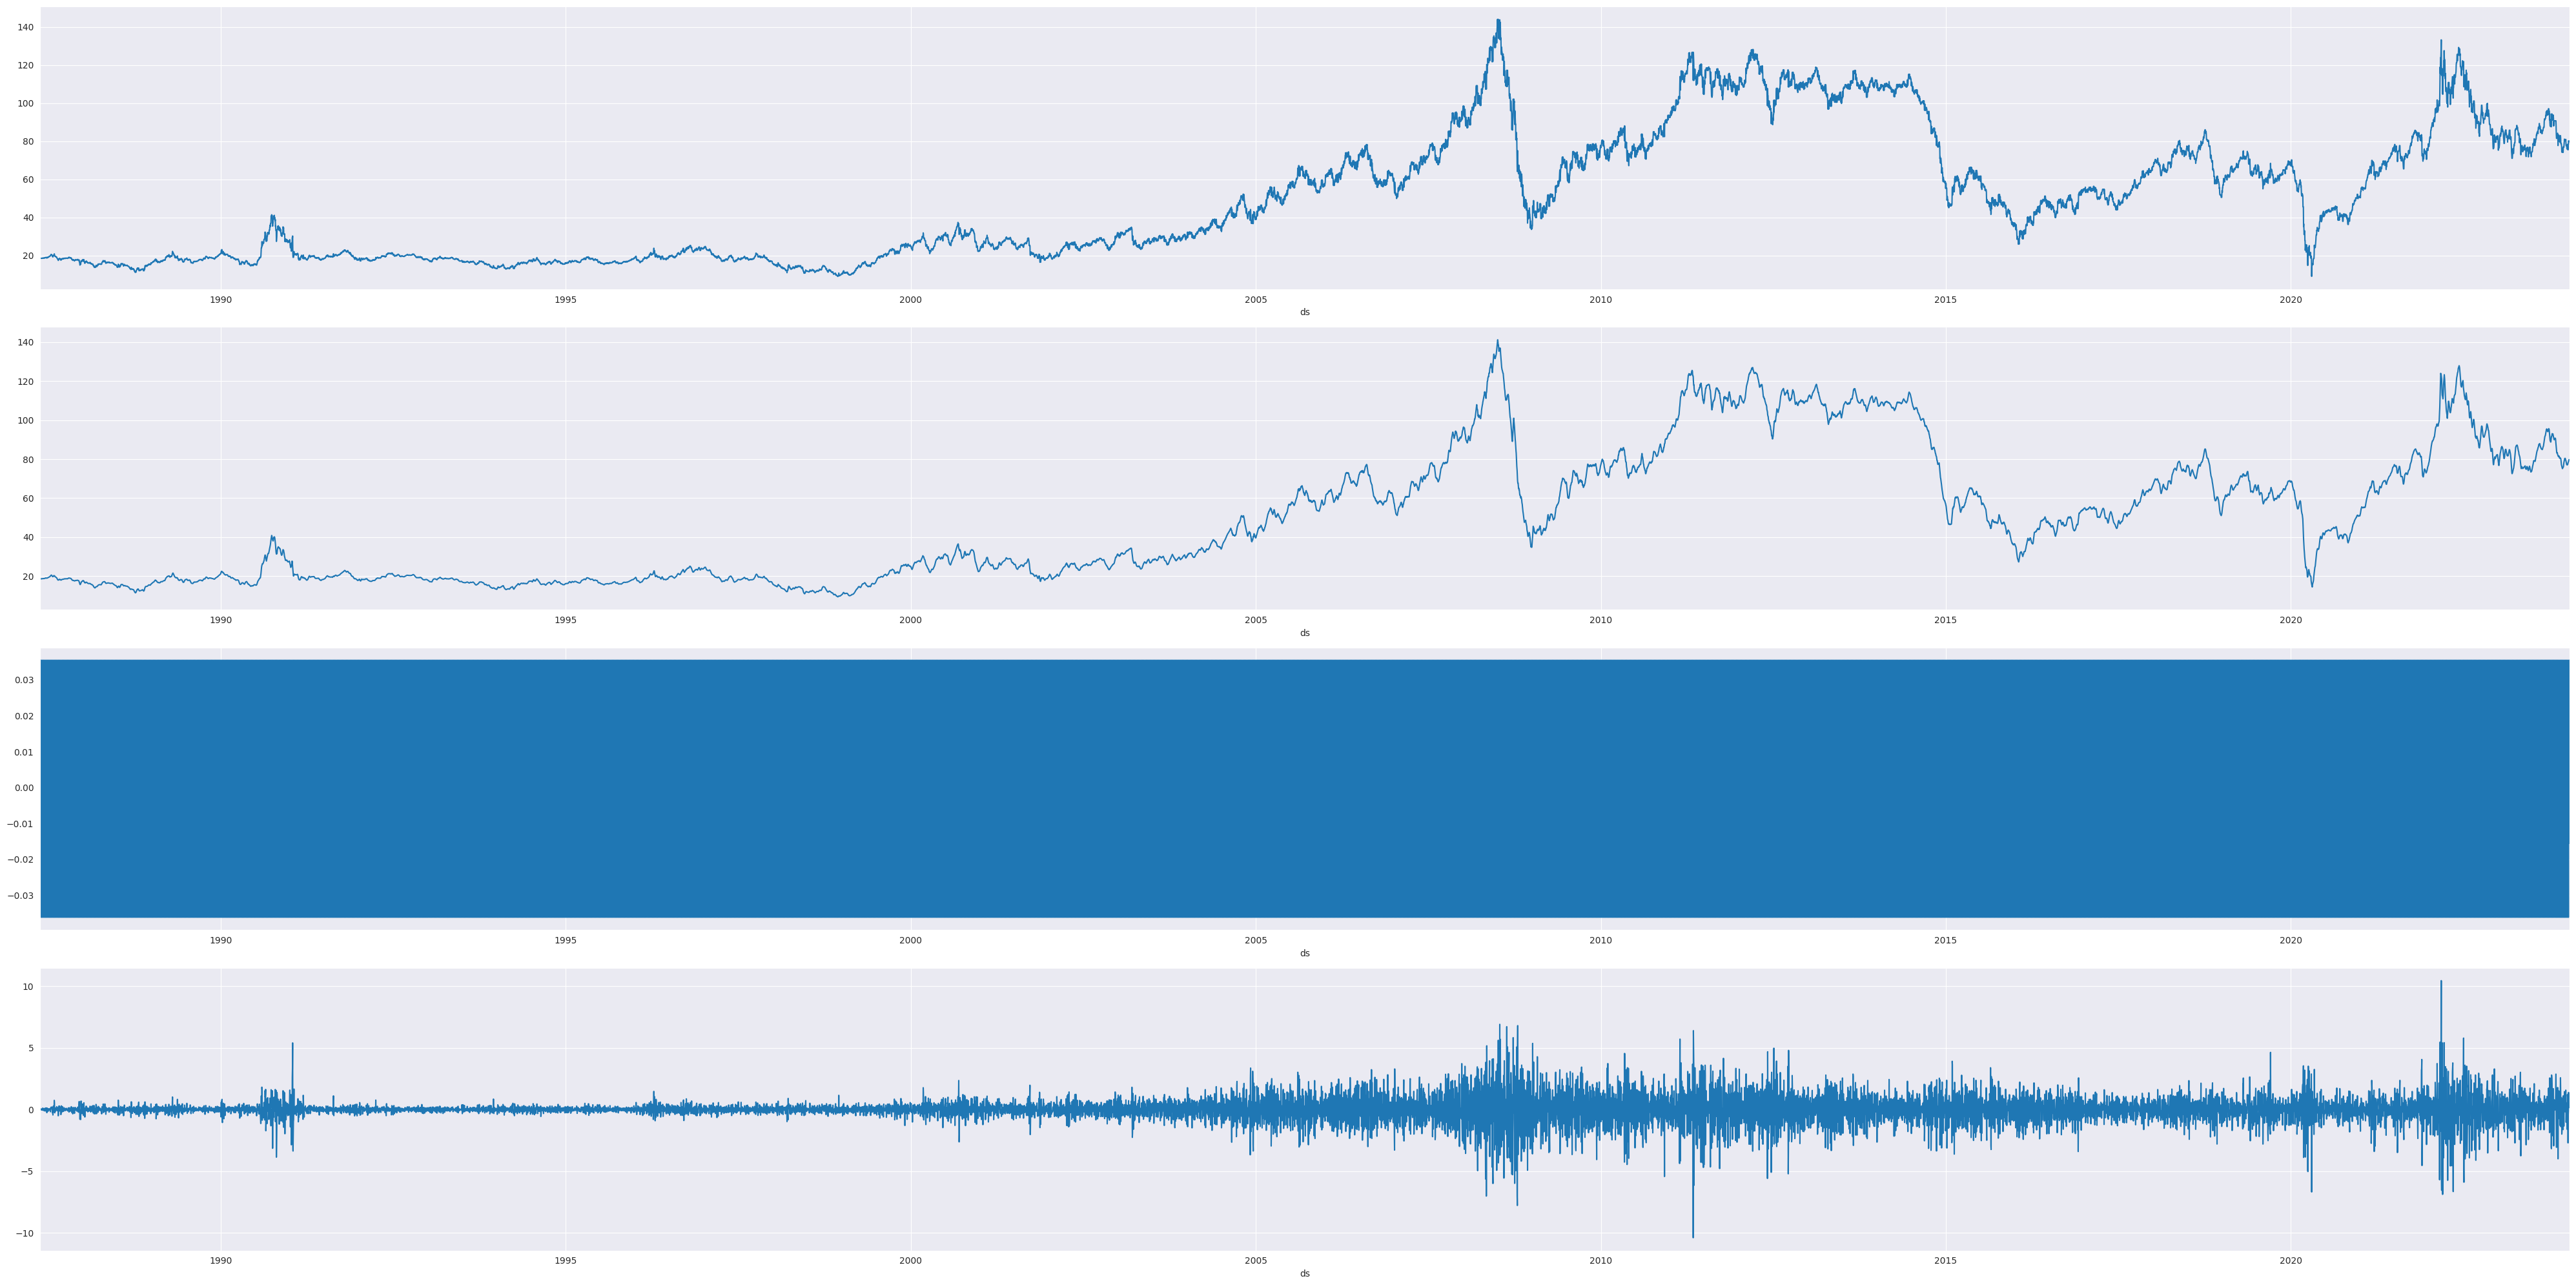

In [69]:
results = seasonal_decompose(df_preco_petroleo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (40,20))

results.observed.plot(ax=ax1)
results.trend.plot(ax=ax2)
results.seasonal.plot(ax=ax3)
results.resid.plot(ax=ax4)

plt.tight_layout()

A partir dos gráficos acima, pode-se constatar que:

**Análise da Tendência**

A tendência é crescente, indicando um aumento ao longo do tempo, contudo, não pode ser definido como um aumento constante.


**Análise da Sazonalidade**

Não há uma definição de períodos de sazonalidade.


**Análise dos Resíduos**

Os resíduos variam bastante ao longo do tempo, com uma certa tendencia de crescimento e com alguns picos bem definidos.


## Augmented Dickey-Fuller (ADF) e Transformações


O Augmented Dickey-Fuller (ADF) é um teste estatístico utilizado para avaliar a estacionariedade em séries temporais. A estacionariedade é uma propriedade importante, pois muitos modelos de análise de séries temporais assumem que os dados sejam estacionários. A estacionariedade implica que as propriedades estatísticas da série, como a média e a variância, permaneçam constantes ao longo do tempo. Como resultado, o ADF retorna um valor de teste estatístico um p-value.

- **Hipótese Nula (H0):** a hipótese nula assume que a série temporal é não estacionária. Ou seja, ela possui raiz unitária, o que significa que a série possui alguma forma de tendência ou estrutura não estacionária.

- **Hipótese Alternativa (H1):** a hipótese alternativa é a oposta da hipótese nula. Se o p-value for suficientemente baixo, você rejeita a hipótese nula e conclui que a série é estacionária.

Analisando o resultado:

- Se o p-value for menor que o nível de significância adotado (0,05) a hipótese nula é rejeitada e conclui-se que a série é estacionária. Além disso, também vamos analisar se o valor do teste estatísico é menor que o valor crítico de 5%

- Se o valor-p for maior que o nível de significância, a hipótese nula não pode ser rejeitada, o que sugere que a série é não estacionária.

In [70]:
X = df_preco_petroleo.y.values
adf_result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")
print("Valores críticos:")

for key, value in adf_result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.0088529843714023
P-Value: 0.2827049157450344
Valores críticos:
	1%: -3.4308399661336604
	5%: -2.8617565418684556
	10%: -2.5668852603511683


Seguindo as regras acima descritas, pode-se confirmar que a série não é estacionária. Também podemos fazer a análise gráfica.

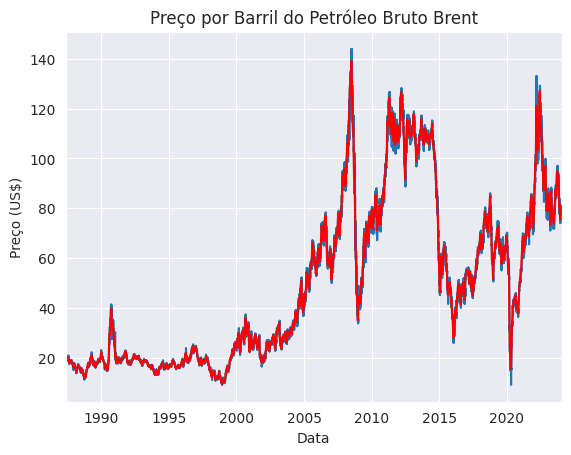

In [71]:
ma = df_preco_petroleo.rolling(12).mean()

f, ax = plt.subplots()
df_preco_petroleo.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (US$)')
ax.set_title('Preço por Barril do Petróleo Bruto Brent')
f.show()

Como vários modelos serão testados, incluindo o ARIMA, é necessário transformá-la em uma série estacionária.

Para isso, primeiramente, vamos aplicar a função de log:

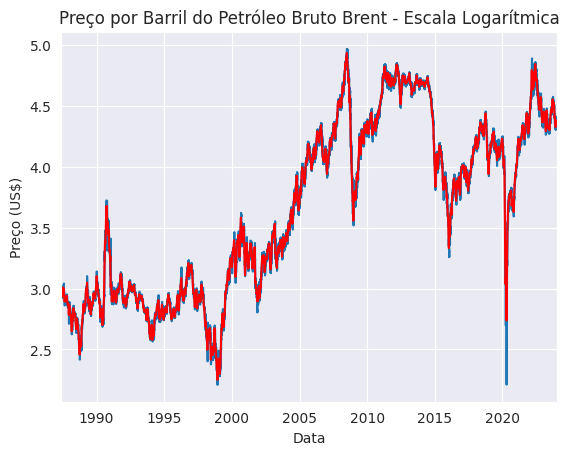

In [72]:
df_preco_petroleo_log = np.log(df_preco_petroleo)
ma_log = df_preco_petroleo_log.rolling(12).mean()

f, ax = plt.subplots()
df_preco_petroleo_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (US$)')
ax.set_title('Preço por Barril do Petróleo Bruto Brent - Escala Logarítmica')
f.show()

Através do gráfico acima, pode-se constatar que a escala foi ajustada, porém ainda não aparenta ser uma série estacionária. Aplicaremos novamente o ADF para comprovar:

In [73]:
X_log = df_preco_petroleo_log.y.values
adf_result_log = adfuller(X_log)

print("Teste ADF")
print(f"Teste Estatístico: {adf_result_log[0]}")
print(f"P-Value: {adf_result_log[1]}")
print("Valores críticos:")

for key, value in adf_result_log[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.8388390436974988
P-Value: 0.36135669701239603
Valores críticos:
	1%: -3.430839819332081
	5%: -2.861756476994448
	10%: -2.56688522581927


Confirmamos que a série ainda é não estacionária.


Então, vamos aplicar a subtração do valor pela média móvel

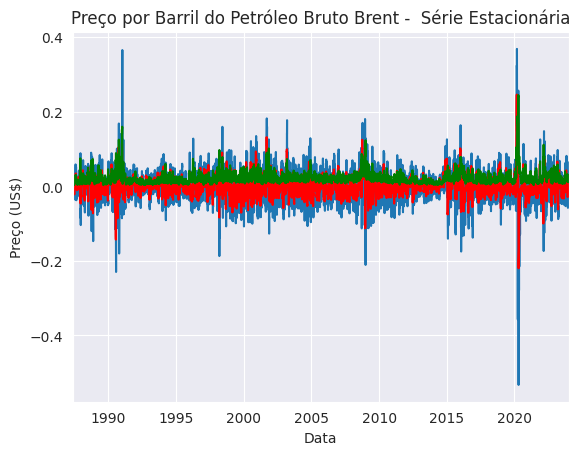

In [74]:
df_preco_petroleo_s = (df_preco_petroleo_log - ma_log).dropna()

ma_s = df_preco_petroleo_s.rolling(12).mean()

std = df_preco_petroleo_s.rolling(12).std()

f, ax = plt.subplots()
df_preco_petroleo_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (US$)')
ax.set_title('Preço por Barril do Petróleo Bruto Brent -  Série Estacionária')
f.show()

Aparentemente, a série se tornou estacionária. Vamos realizar o teste novamente para confirmar.

In [75]:
X_s = df_preco_petroleo_s.y.values
adf_result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {adf_result_s[0]}")
print(f"P-Value: {adf_result_s[1]}")
print("Valores críticos:")

for key, value in adf_result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -16.010994182925646
P-Value: 6.356072940363068e-29
Valores críticos:
	1%: -3.4308402232482718
	5%: -2.8617566554915803
	10%: -2.5668853208318207


Agora que confirmamos que a série é estacionária, podemos utilizar o dataframe **df_preco_petroleo_s** quando quisermos utilizá-la transformada, nos modelos que não necessitam, ainda podemos utilizar o dataframe original **df_preco_petroleo**.

## ACF e PACF


O ACF (AutoCorrelation Function) e o PACF (Partial AutoCorrelation Function) são ferramentas essenciais na análise de séries temporais. Eles são usados para entender a estrutura de dependência temporal nos dados e são fundamentais para a modelagem e previsão de séries temporais.

**ACF**

- Quanto um período está relacionado com o outro, direta e indiretamente

**PACF**

- Quanto um período está relacionado apenas diretamente

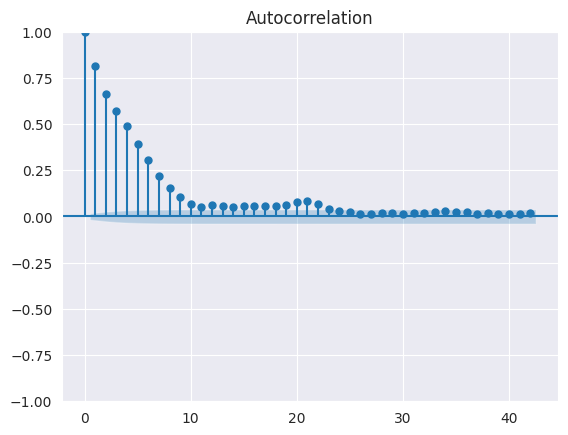

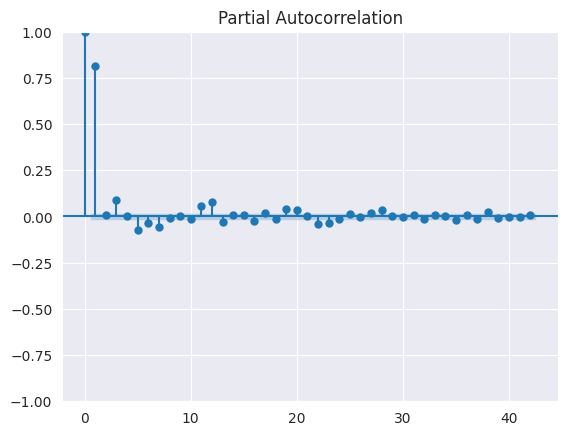

In [76]:
plot_acf(df_preco_petroleo_s.y)
plot_pacf(df_preco_petroleo_s.y)
plt.show()

Embora seja uma função composta, há uma relação forte do preço anterior do barril de petróleo bruto Brent com o próximo.

## Funçoes de Validação

### WMAPE

O WMAPE (Weighted Mean Absolute Percentage Error) é uma métrica de avaliação usada na análise de séries temporais e previsão. Ele mede a precisão de um modelo de previsão em relação aos valores reais, levando em consideração pesos, caso necessário.

Uma pontuação mais baixa de WMAPE indica maior precisão na previsão, mas a interpretação depende do contexto e da relevância dos dados.

In [77]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

### Erro Médio Percentual Absoluto (MAPE)


O MAPE (Mean Absolute Percentage Error), é uma medida usada para avaliar a precisão de previsões em relação aos valores reais. Ele calcula a média das diferenças absolutas entre as previsões e os valores reais e é expresso em porcentagem.

Quanto menor o valor do MAPE, melhor é a precisão do modelo. Isso indica que as previsões estão, em média, mais próximas dos valores reais. Enquanto um valor alto, indica que as previsões estão longe dos valores observados e que o modelo precisa ser revisto.

In [78]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true.values - y_pred.values)/ y_true.values))

### RMSE


O RMSE (Root Mean Square Error) é uma métrica comum de avaliação em análise de séries temporais e previsão. Ele mede o erro médio quadrático entre as previsões e os valores reais, proporcionando uma medida da precisão do modelo.

Quanto menor o valor do RMSE, maior a precisão da previsão. No entanto, sua interpretação deve levar em conta a escala dos dados e o contexto do problema.

In [79]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

## Statsforecast


O StatsForecast é um pacote em Python que oferece funcionalidades para modelagem e previsão de séries temporais.

### Formatação dos Dados


Para utilizar o StatsForecast, é necessário fornecer como entrada um dataframe com as colunas **ds**, **y** e **unique_id**, em que **ds** representa a data associada a cada ponto dos dados da série temporal, **y** os valores numéricos e **unique_id** uma chave única.

Desse modo, vamos reutilizar o **df_statsforecast** utilizando o valor do índice de data para criar uma coluna ds e incluindo o id necessário.

**Obs.:** devido as análises feitas anteriormente, não iremos utilizar a série transformada em estacionária, mas sim a série original não estacionária apenas com os tratamentos de dias faltantes.

In [102]:
pipeline2 = Pipeline([
  ('transform_index_to_column', TransformIndexToColumn()),
  ('add_column', AddColumn())
])

df_statsforecast = pipeline2.transform(df_preco_petroleo.copy())
df_statsforecast.head()

,y,ds,unique_id
0,80.15,2024-01-16,value
1,79.76,2024-01-15,value
2,79.89,2024-01-14,value
3,79.89,2024-01-13,value
4,79.89,2024-01-12,value


### Modelagem

Para iniciar a modelagem, dividiremos os dados em dois grupos: treino e teste.

Dividir os dados em treino e teste no contexto de séries temporais é uma boa prática porque reflete a natureza do problema de previsão temporal. A ordem temporal dos dados é fundamental em séries temporais, pois a informação do passado é usada para prever o futuro. Dividir os dados em treino e teste permite simular essa situação realista, treinando o modelo em dados anteriores e avaliando sua capacidade de prever dados futuros não vistos. Isso ajuda a verificar se o modelo é capaz de generalizar e fazer previsões precisas em cenários reais, evitando vazamento de informações do futuro para o passado.

In [103]:
treino = df_statsforecast[(df_statsforecast['ds'] >= '2022-10-01') & (df_statsforecast['ds'] < '2023-10-01')]
valid = df_statsforecast[(df_statsforecast['ds'] >= '2023-10-01') &  (df_statsforecast['ds'] < '2024-01-16')]

h = valid.index.nunique()

### Execução dos Modelos

#### Naive


Para iniciarmos a análise do StatsForecast, vamos utilizar o modelo básico Naive que é uma abordagem simples em que a previsão para o próximo período é igual à última observação conhecida.

In [106]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

forecast_naive = model.predict(h=h, level=[90])
forecast_naive = forecast_naive.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
rmse1 = rmse(forecast_naive['y'].values, forecast_naive['Naive'].values)
mape1 = mape(forecast_naive['y'], forecast_naive['Naive'])

print(f"WMAPE: {wmape1:.2%}")
print(f"RMSE: {rmse1:.2f}")
print(f"MAPE: {mape1:.2%}")


df_statsforecast_filtered = df_statsforecast[df_statsforecast['ds'] >= pd.to_datetime('2023-06-01')]

fig = go.Figure()

# série temporal prevista e intervalo de confiança
fig.add_trace(go.Scatter(x=forecast_naive['ds'], y=forecast_naive['Naive'], mode='lines', name='Previsão (Naive)', line=dict(color='rgb(101, 101, 101)')))
fig.add_trace(go.Scatter(x=forecast_naive['ds'], y=forecast_naive['Naive-lo-90'], fill=None, mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast_naive['ds'], y=forecast_naive['Naive-hi-90'], fill='tonexty', mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=df_statsforecast_filtered['ds'], y=df_statsforecast_filtered['y'], mode='lines', name='Valor Real', line=dict(color='blue')))

fig.update_layout(title='Previsão do Preço (US$) do Petróleo Brent Utilizando o Modelo Naive', xaxis_title='Data', yaxis_title='Preço (US$)', width=1000)
fig.show()



WMAPE: 15.01%
RMSE: 13.92
MAPE: 15.61%


Podemos constatar que o modelo não obteve um bom resultado, pois a previsão realizada através do último valor conhecido, não captura o comportamento dos dados.

#### Seasonal Naive

O Seasonal Naive é um modelo semelhante ao Naive, mas é aplicado a séries temporais sazonais. A previsão para o próximo período é igual à observação do mesmo período na temporada anterior.

Para buscar o melhor resultado possível, vamos utilizar uma técnica para encontrar o melhor valor de season_length possível.

In [108]:
best_mape_seasonal_naive = np.inf
best_season_length_seasonal_naive = None

# Grid Search for SeasonalNaive
for season_length in range(7, 365):
    model_s_1 = StatsForecast(models=[SeasonalNaive(season_length=season_length)], freq='D', n_jobs=-1)
    model_s_1.fit(treino)

    # Make predictions on validation set
    forecast_seasonal_naive_1 = model_s_1.predict(h=h,  level=[90])
    forecast_seasonal_naive_1 = forecast_seasonal_naive_1.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

    # Calculate MAPE
    wmape99 = wmape(forecast_seasonal_naive_1['y'].values, forecast_seasonal_naive_1['SeasonalNaive'].values)

    # Update best parameters if necessary
    if wmape99 < best_mape_seasonal_naive:
        best_mape_seasonal_naive = wmape99
        best_season_length_seasonal_naive = season_length

print("Best Season Length:", best_season_length_seasonal_naive)

Best Season Length: 341


O melhor Season Length foi de 341 para os parâmetros de treino utilizado.

In [110]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=best_season_length_seasonal_naive)], freq='D', n_jobs=-1)
fitted_model = model_s.fit(treino)

forecast_seasonal_naive = model_s.predict(h=h, level=[90])
forecast_seasonal_naive = forecast_seasonal_naive.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_seasonal_naive['y'].values, forecast_seasonal_naive['SeasonalNaive'].values)
rmse2 = rmse(forecast_seasonal_naive['y'].values, forecast_seasonal_naive['SeasonalNaive'].values)
mape2 = mape(forecast_seasonal_naive['y'], forecast_seasonal_naive['SeasonalNaive'])

print(f"WMAPE: {wmape2:.2%}")
print(f"RMSE: {rmse2:.2f}")
print(f"MAPE: {mape2:.2%}")

fig = go.Figure()

# série temporal prevista e intervalo de confiança
fig.add_trace(go.Scatter(x=forecast_seasonal_naive['ds'], y=forecast_seasonal_naive['SeasonalNaive'], mode='lines', name='Previsão (Seasonal Naive)', line=dict(color='rgb(101, 101, 101)')))
fig.add_trace(go.Scatter(x=forecast_seasonal_naive['ds'], y=forecast_seasonal_naive['SeasonalNaive-lo-90'], fill=None, mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast_seasonal_naive['ds'], y=forecast_seasonal_naive['SeasonalNaive-hi-90'], fill='tonexty', mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=df_statsforecast_filtered['ds'], y=df_statsforecast_filtered['y'], mode='lines', name='Valor Real', line=dict(color='blue')))

fig.update_layout(title='Previsão do Preço (US$) do Petróleo Brent Utilizando o Modelo Seasonal Naive', xaxis_title='Data', yaxis_title='Preço (US$)', width=1000)
fig.show()

WMAPE: 4.74%
RMSE: 4.88
MAPE: 4.78%


Ao utilizar o Seasonal Naive, percebemos que o WMAPE: 4.74%, RMSE: 4.88 e MAPE: 4.78% obtiveram resultados melhores, além do fato dele indicar uma previsão mais próxima dos dados reais, quando comparado com os resultados obtidos no modelo Naive (WMAPE: 15.01%, RMSE: 13.92 e MAPE: 15.61%).

#### Seasonal Window Average

Este modelo usa uma média móvel para suavizar as flutuações sazonais nos dados. A previsão é obtida tirando a média dos valores nas janelas temporais correspondentes na temporada anterior.

Para buscar o melhor resultado possível, vamos utilizar uma técnica para encontrar o melhor valor de season_length e window_size possível.

In [111]:
best_mape_swa = np.inf
best_season_length_swa = None
best_window_size_swa = None

# Grid Search for SeasonalWindowAverage
for season_length in range(7, 365):
    for window_size in [2, 7, 14, 30, 90, 180, 181, 270]:
        model_sm_1 = StatsForecast(models=[SeasonalWindowAverage(season_length=season_length, window_size=window_size)], freq='D', n_jobs=-1)
        model_sm_1.fit(treino)

        # Make predictions on validation set
        forecast_dfsm_1 = model_sm_1.predict(h=h)
        forecast_dfsm_1 = forecast_dfsm_1.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

        # Calculate MAPE
        wmape98 = wmape(forecast_dfsm_1['y'].values, forecast_dfsm_1['SeasWA'].values)

        # Update best parameters if necessary
        if wmape98 < best_mape_swa:
            best_mape_swa = wmape98
            best_season_length_swa = season_length
            best_window_size_swa = window_size

print("Best Season Length:", best_season_length_swa)
print("Best Window Size:", best_window_size_swa)

Best Season Length: 181
Best Window Size: 2


In [112]:
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=best_season_length_swa, window_size=best_window_size_swa)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dfsm = model_sm.predict(h=h)
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape3 = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
rmse3 = rmse(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
mape3 = mape(forecast_dfsm['y'], forecast_dfsm['SeasWA'])

print(f"WMAPE: {wmape3:.2%}")
print(f"RMSE: {rmse3:.2f}")
print(f"MAPE: {mape3:.2%}")


fig = go.Figure()

# série temporal prevista e intervalo de confiança
fig.add_trace(go.Scatter(x=forecast_dfsm['ds'], y=forecast_dfsm['SeasWA'], mode='lines', name='Previsão (SeasWA)', line=dict(color='rgb(101, 101, 101)')))
fig.add_trace(go.Scatter(x=df_statsforecast_filtered['ds'], y=df_statsforecast_filtered['y'], mode='lines', name='Valor Real', line=dict(color='blue')))

fig.update_layout(title='Previsão do Preço (US$) do Petróleo Brent Utilizando o Modelo Seasonal Window Average', xaxis_title='Data', yaxis_title='Preço (US$)', width=1000)
fig.show()

WMAPE: 2.76%
RMSE: 2.87
MAPE: 2.69%


Utilizando a sazonalidade de 181 e a janela de 2, o Seasonal Window Average obteve resultados excelentes (WMAPE: 2.76%, RMSE: 2.87 e MAPE: 2.69%), quando comparado aos modelos anteriores, além de conseguir capturar bem o comportamento dos dados.

#### Seasonal Exponential Smoothing Optimized

A suavização exponencial é uma técnica que atribui pesos decrescentes às observações passadas. A versão sazonal otimizada estende isso para capturar padrões sazonais. É um método mais avançado que ajusta automaticamente os parâmetros para otimizar a precisão da previsão.

Para buscar o melhor resultado possível, vamos utilizar uma técnica para encontrar o melhor valor de season_length possível.

In [113]:
best_mape_seso = np.inf
best_season_length_seso = None

# Grid Search for SeasonalExponentialSmoothingOptimized
for season_length in range(7, 365):
    model_seso_1 = StatsForecast(models=[SeasonalExponentialSmoothingOptimized(season_length=season_length)], freq='D', n_jobs=-1)
    model_seso_1.fit(treino)

    # Make predictions on validation set
    forecast_seasonal_exp_smo_opt_1 = model_seso_1.predict(h=h)
    forecast_seasonal_exp_smo_opt_1 = forecast_seasonal_exp_smo_opt_1.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

    # Calculate MAPE
    wmape97 = wmape(forecast_seasonal_exp_smo_opt_1['y'].values, forecast_seasonal_exp_smo_opt_1['SeasESOpt'].values)

    # Update best parameters if necessary
    if wmape97 < best_mape_seso:
        best_mape_seso = wmape97
        best_season_length_seso = season_length
        best_window_size = window_size

print("Best Season Length:", best_season_length_seso)

Best Season Length: 171


In [114]:
model_seso = StatsForecast(models=[SeasonalExponentialSmoothingOptimized(season_length=best_season_length_seso)], freq='D', n_jobs=-1)
model_seso.fit(treino)

forecast_seasonal_exp_smo_opt = model_seso.predict(h=h)
forecast_seasonal_exp_smo_opt = forecast_seasonal_exp_smo_opt.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape4 = wmape(forecast_seasonal_exp_smo_opt['y'].values, forecast_seasonal_exp_smo_opt['SeasESOpt'].values)
rmse4 = rmse(forecast_seasonal_exp_smo_opt['y'].values, forecast_seasonal_exp_smo_opt['SeasESOpt'].values)
mape4 = mape(forecast_seasonal_exp_smo_opt['y'], forecast_seasonal_exp_smo_opt['SeasESOpt'])

print(f"WMAPE: {wmape4:.2%}")
print(f"RMSE: {rmse4:.2f}")
print(f"MAPE: {mape4:.2%}")

fig = go.Figure()

# série temporal prevista e intervalo de confiança
fig.add_trace(go.Scatter(x=forecast_seasonal_exp_smo_opt['ds'], y=forecast_seasonal_exp_smo_opt['SeasESOpt'], mode='lines', name='Previsão (SeasESOpt)', line=dict(color='rgb(101, 101, 101)')))
fig.add_trace(go.Scatter(x=df_statsforecast_filtered['ds'], y=df_statsforecast_filtered['y'], mode='lines', name='Valor Real', line=dict(color='blue')))

fig.update_layout(title='Previsão do Preço (US$) do Petróleo Brent Utilizando o Modelo Seasonal Exponential Smoothing Optimized', xaxis_title='Data', yaxis_title='Preço (US$)', width=1000)
fig.show()

WMAPE: 4.73%
RMSE: 4.80
MAPE: 4.78%


Utilizando a sazonalidade de 171 dias, o modelo Seasonal Exponential Smoothing Optimized conseguiu obter bons resultados (WMAPE: 4.73%, RMSE: 4.80 e MAPE: 4.78%), porém não conseguiu superar o modelo Seasonal Window Average.

#### AutoARIMA

AutoARIMA é uma abordagem automatizada baseada em aprendizado de máquina para ajustar modelos ARIMA (AutoRegressive Integrated Moving Average). Ele procura automaticamente pelos melhores parâmetros do modelo ARIMA para a série temporal fornecida. Isso inclui termos autoregressivos (AR), termos de diferenciação (I) e termos de média móvel (MA). Para a execução do AutoARIMA, foram utilizados os dados da série convertida em estacionária.

In [116]:
df_statsforecast_auto_arima = pipeline2.transform(df_preco_petroleo_s.copy())
df_statsforecast_auto_arima.head()

,y,ds,unique_id
0,-0.007174,2024-01-05,value
1,-0.035222,2024-01-04,value
2,-0.014308,2024-01-03,value
3,-0.022665,2024-01-02,value
4,-0.001498,2024-01-01,value


In [117]:
treino_auto_arima = df_statsforecast_auto_arima[(df_statsforecast_auto_arima['ds'] >= '2022-10-01') & (df_statsforecast_auto_arima['ds'] < '2023-10-01')]
valid_auto_arima = df_statsforecast_auto_arima[(df_statsforecast_auto_arima['ds'] >= '2023-10-01') &  (df_statsforecast_auto_arima['ds'] < '2024-01-16')]

h = valid_auto_arima.index.nunique()

In [120]:
df_preco_petroleo_s_filtered = df_preco_petroleo_s[df_preco_petroleo_s.index >= '2023-06-01']

In [124]:
model_a = StatsForecast(models=[AutoARIMA(season_length=30)], freq='D', n_jobs=-1)
model_a.fit(treino_auto_arima)

forecast_autorima = model_a.predict(h=h, level=[90])
forecast_autorima = forecast_autorima.reset_index().merge(valid_auto_arima, on=['ds', 'unique_id'], how='left')

wmape5 = wmape(forecast_autorima['y'].values, forecast_autorima['AutoARIMA'].values)
mape5 = mape(forecast_autorima['y'], forecast_autorima['AutoARIMA'])
print(f"WMAPE: {wmape5:.2%}")
print(f"MAPE: {mape5:.2%}")

fig = go.Figure()

# série temporal prevista e intervalo de confiança
fig.add_trace(go.Scatter(x=forecast_autorima['ds'], y=forecast_autorima['AutoARIMA'], mode='lines', name='Previsão (AutoARIMA)', line=dict(color='rgb(101, 101, 101)')))
fig.add_trace(go.Scatter(x=forecast_autorima['ds'], y=forecast_autorima['AutoARIMA-lo-90'], fill=None, mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast_autorima['ds'], y=forecast_autorima['AutoARIMA-hi-90'], fill='tonexty', mode='lines', line=dict(color='gray', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=df_preco_petroleo_s_filtered.index, y=df_preco_petroleo_s_filtered['y'], mode='lines', name='Valor Real', line=dict(color='blue')))

fig.update_layout(title='Previsão do Preço (US$) do Petróleo Brent Utilizando o Modelo AutoARIMA', xaxis_title='Data', yaxis_title='Preço (US$)', width=1000)
fig.show()

WMAPE: 101.27%
MAPE: 109.76%


Conforme visto, devido a natureza da série, o AutoARIMA acabou obtendo resultados péssimos.

## Conclusão

Com base na análise comparativa dos modelos Naive, Seasonal Naive, Seasonal Window Average, Seasonal Exponential Smoothing Optimized e AutoARIMA, aplicados à série temporal de preços do petróleo Brent, obtidos do site do IPEA, e utilizando métricas de validação como WMAPE, MAPE e RMSE, constatou-se que o modelo que apresentou os resultados mais satisfatórios e que melhor capturou o comportamento dos dados foi o Seasonal Window Average.

In [125]:
joblib.dump(model_sm, 'sm.joblib')

['sm.joblib']